In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from cmocean import cm
from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#cluster = PBSCluster(cores=28, processes=18, walltime='00:40:00')
w = cluster.scale(10)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.87:47106 Dashboard: http://10.148.1.87:8787/status,Cluster Workers: 14 Cores: 14 Memory: 239.96 GB


_________
# 1. Read dataset


In [5]:
out_dir_work = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'


grid = xr.open_dataset(out_dir_work+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_work+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_work+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_work+'W_total_rechunk.zarr')
#ds_D = xr.open_zarr(out_dir_work+'Buoy_total_rechunk.zarr')
#ds_KPP = xr.open_zarr(out_dir_work+'KPPhbl_total_rechunk.zarr')

# buoyancy
#ds_B = -9.81*(ds_D.Pden-25)/1025
#ds_B = np.real(ds_B).rename('Buoy')
#ds_B = ds_B.to_dataset()

ds = xr.merge([ds_U,ds_V,ds_W,grid])
#ds = xr.merge([ds_U,ds_V,ds_KPP,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 ...
   

# 2. Filter

In [6]:
out_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/temporary/'

def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

## 2.1 bandpass (1-5 days)

In [7]:
lowcut = 1/120/3600
highcut = 1/24/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq
high = highcut/nyq

b, a = butter(4, [low, high], 'bandpass')

In [ ]:
# rechunk data first
#chunks = {'time': 9415, 'lat': 1, 'lon_g': 1, 'depth':52}
#U = ds.U.chunk(chunks)
#del U.depth.encoding['chunks']

# filter
U = ds.U
U_filter = butter_filter(U.isel(time=slice(0,8761),depth=slice(0,40)), b, a)
U_bandpass_filter = np.real(U_filter).rename('U_bandpass_filter')
U_bandpass_filter = U_bandpass_filter.to_dataset()

# rechunk data again
chunks = {'time': 8761, 'lat': 1, 'lon_g': 177, 'depth':1}
U_bandpass_filter = U_bandpass_filter.chunk(chunks)
print(U_bandpass_filter)
# save
file_out = out_dir_zarr+'/U_bandpass_filter_rechunk.zarr'
%time U_bandpass_filter.to_zarr(file_out, mode='w')  

In [11]:
# rechunk data first
chunks = {'time': 9415, 'lat_g': 1, 'lon': 1, 'depth':52}
V = ds.V.chunk(chunks)
del V.depth.encoding['chunks']

# filter
V_filter = butter_filter(V.isel(time=slice(0,8761),depth=slice(0,40)), b, a)
V_bandpass_filter = np.real(V_filter).rename('V_bandpass_filter')
V_bandpass_filter = V_bandpass_filter.to_dataset()

# rechunk data again
chunks = {'time': 8761, 'lat_g': 1, 'lon': 177, 'depth':1}
V_bandpass_filter = V_bandpass_filter.chunk(chunks)

# save
file_out = out_dir_zarr+'/V_bandpass_filter_rechunk.zarr'
%time V_bandpass_filter.to_zarr(file_out, mode='w')   

CPU times: user 2min 26s, sys: 6.33 s, total: 2min 32s
Wall time: 3min 9s


In [18]:
# rechunk data first
chunks = {'time': 9415, 'lat': 1, 'lon': 1, 'depth':52}
W = ds.W.chunk(chunks)
del W.depth.encoding['chunks']

# filter
W_filter = butter_filter(W, b, a)
W_bandpass_filter = np.real(W_filter).rename('W_bandpass_filter')
W_bandpass_filter = W_bandpass_filter.to_dataset()

# rechunk data again
chunks = {'time': 9415, 'lat': 1, 'lon': 177, 'depth':1}
W_bandpass_filter = W_bandpass_filter.chunk(chunks)

# save
file_out = out_dir_zarr+'/W_bandpass_filter_rechunk.zarr'
%time W_bandpass_filter.to_zarr(file_out, mode='w')   

CPU times: user 4min 1s, sys: 6.76 s, total: 4min 7s
Wall time: 6min 55s


## 2.2 low-pass (120 hours)

In [12]:
lowcut = 1/120/3600
highcut = 1/30/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq
high = highcut/nyq

c, d = butter(4, low, 'low')

In [13]:
# rechunk data first
chunks = {'time': 9415, 'lat': 1, 'lon_g': 1, 'depth':52}
U = ds.U.chunk(chunks)
del U.depth.encoding['chunks']

# filter
U_filter = butter_filter(U.isel(time=slice(0,8761),depth=slice(0,40)), c, d)
U_low_filter = np.real(U_filter).rename('U_low_filter')
U_low_filter = U_low_filter.to_dataset()

# rechunk data again
chunks = {'time': 8761, 'lat': 1, 'lon_g': 177, 'depth':1}
U_low_filter = U_low_filter.chunk(chunks)

# save
file_out = out_dir_zarr+'/U_lowpass_filter_rechunk.zarr'
%time U_low_filter.to_zarr(file_out, mode='w')   

CPU times: user 2min 47s, sys: 6.02 s, total: 2min 53s
Wall time: 3min 33s


In [14]:
# rechunk data first
chunks = {'time': 9415, 'lat_g': 1, 'lon': 1, 'depth':52}
V = ds.V.chunk(chunks)
del V.depth.encoding['chunks']

# filter
V_filter = butter_filter(V.isel(time=slice(0,8761),depth=slice(0,40)), c, d)
V_low_filter = np.real(V_filter).rename('V_low_filter')
V_low_filter = V_low_filter.to_dataset()

# rechunk data again
chunks = {'time': 8761, 'lat_g': 1, 'lon': 177, 'depth':1}
V_low_filter = V_low_filter.chunk(chunks)

# save
file_out = out_dir_zarr+'/V_lowpass_filter_rechunk.zarr'
%time V_low_filter.to_zarr(file_out, mode='w')   

CPU times: user 2min 25s, sys: 4.98 s, total: 2min 30s
Wall time: 2min 56s


In [11]:
# rechunk data first
chunks = {'time': 9415, 'lat': 1, 'lon': 1, 'depth':52}
W = ds.W.chunk(chunks)
del W.depth.encoding['chunks']

# filter
W_filter = butter_filter(W, c, d)
W_low_filter = np.real(W_filter).rename('W_low_filter')
W_low_filter = W_low_filter.to_dataset()

# rechunk data again
chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
W_low_filter = W_low_filter.chunk(chunks)

# save
file_out = out_dir_zarr+'/W_lowpass_filter_rechunk.zarr'
%time W_low_filter.to_zarr(file_out, mode='w')   

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 3min 10s, sys: 5.66 s, total: 3min 16s
Wall time: 5min 37s


## 2.3 low-pass (30 hours)

In [7]:
lowcut = 1/120/3600
highcut = 1/30/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq
high = highcut/nyq

e, f = butter(4, high, 'low')

In [8]:
# rechunk data first
chunks = {'time': 9415, 'lat': 1, 'lon_g': 1, 'depth':52}
U = ds.U.chunk(chunks)
del U.depth.encoding['chunks']

# filter
U_filter = butter_filter(U.isel(time=slice(0,8761),depth=slice(0,40)), e, f)
U_low_filter = np.real(U_filter).rename('U_low_filter')
U_low_filter = U_low_filter.to_dataset()

# rechunk data again
chunks = {'time': 8761, 'lat': 1, 'lon_g': 177, 'depth':1}
U_low_filter = U_low_filter.chunk(chunks)
print(U_low_filter)
# save
file_out = out_dir_zarr+'/U_lowpass_30h_filter_rechunk.zarr'
%time U_low_filter.to_zarr(file_out, mode='w')   

<xarray.Dataset>
Dimensions:       (depth: 40, lat: 201, lon_g: 177, time: 8761)
Coordinates:
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon_g         (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 441.3 473.3 506.5
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-09-12
    dxC           (lat, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    dyG           (lat, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    rAw           (lat, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
Data variables:
    U_low_filter  (time, depth, lat, lon_g) float32 dask.array<chunksize=(8761, 1, 1, 177), meta=np.ndarray>
CPU times: user 2min 42s, sys: 7.67 s, total: 2min 49s
Wall time: 4min 5s


In [9]:
# rechunk data first
chunks = {'time': 9415, 'lat_g': 1, 'lon': 1, 'depth':52}
V = ds.V.chunk(chunks)
del V.depth.encoding['chunks']

# filter
V_filter = butter_filter(V.isel(time=slice(0,8761),depth=slice(0,40)), e, f)
V_low_filter = np.real(V_filter).rename('V_low_filter')
V_low_filter = V_low_filter.to_dataset()

# rechunk data again
chunks = {'time': 8761, 'lat_g': 1, 'lon': 177, 'depth':1}
V_low_filter = V_low_filter.chunk(chunks)
print(V_low_filter)

# save
file_out = out_dir_zarr+'/V_lowpass_30h_filter_rechunk.zarr'
%time V_low_filter.to_zarr(file_out, mode='w')   

<xarray.Dataset>
Dimensions:       (depth: 40, lat_g: 201, lon: 177, time: 8761)
Coordinates:
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 441.3 473.3 506.5
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-09-12
  * lat_g         (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    dyC           (lat_g, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    dxG           (lat_g, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    rAs           (lat_g, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
Data variables:
    V_low_filter  (time, depth, lat_g, lon) float32 dask.array<chunksize=(8761, 1, 1, 177), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


CPU times: user 2min 41s, sys: 6.4 s, total: 2min 47s
Wall time: 3min 40s


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [10]:
# rechunk data first
chunks = {'time': 9415, 'lat': 1, 'lon': 1, 'depth':52}
W = ds.W.chunk(chunks)
del W.depth.encoding['chunks']

# filter
W_filter = butter_filter(W.isel(time=slice(0,8761),depth=slice(0,40)), e, f)
W_low_filter = np.real(W_filter).rename('W_low_filter')
W_low_filter = W_low_filter.to_dataset()

# rechunk data again
chunks = {'time': 8761, 'lat': 1, 'lon': 177, 'depth':1}
W_low_filter = W_low_filter.chunk(chunks)
print(W_low_filter)

# save
file_out = out_dir_zarr+'/W_lowpass_30h_filter_rechunk.zarr'
%time W_low_filter.to_zarr(file_out, mode='w')   

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:       (depth: 40, lat: 201, lon: 177, time: 8761)
Coordinates:
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 441.3 473.3 506.5
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-09-12
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    XC            (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    YC            (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    CS            (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    SN            (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    Depth         (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    rA            (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
Data variables:
    W_low_filter  (time, depth, lat, lon) float32 dask.array<chunksize=(8761, 1, 1, 1

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


CPU times: user 2min 50s, sys: 6.65 s, total: 2min 56s
Wall time: 3min 29s


In [13]:
# rechunk data first
chunks = {'time': 9415, 'lat': 1, 'lon': 1, 'depth':52}
B = ds.Pden.chunk(chunks)
del B.depth.encoding['chunks']

# filter
B_filter = butter_filter(B.isel(time=slice(0,8761),depth=slice(0,40)), e, f)
B_low_filter = np.real(B_filter).rename('B_low_filter')
B_low_filter = B_low_filter.to_dataset()

# rechunk data again
chunks = {'time': 8761, 'lat': 1, 'lon': 177, 'depth':1}
B_low_filter = B_low_filter.chunk(chunks)
print(B_low_filter)

# save
file_out = out_dir_zarr+'/P_lowpass_30h_filter_rechunk.zarr'
%time B_low_filter.to_zarr(file_out, mode='w')   

<xarray.Dataset>
Dimensions:       (depth: 40, lat: 201, lon: 177, time: 8761)
Coordinates:
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 441.3 473.3 506.5
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-09-12
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    XC            (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    YC            (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    CS            (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    SN            (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    Depth         (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    rA            (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
Data variables:
    B_low_filter  (time, depth, lat, lon) float32 dask.array<chunksize=(8761, 1, 1, 1

# 3. read filtered data

In [7]:
out_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/LLC4320/filtered_uv_data/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)

ds_U_bandpass = xr.open_zarr(out_dir_zarr+'U_bandpass_filter_rechunk.zarr')
ds_V_bandpass = xr.open_zarr(out_dir_zarr+'V_bandpass_filter_rechunk.zarr')
#ds_W_bandpass = xr.open_zarr(out_dir_zarr+'W_bandpass_filter_rechunk.zarr')

ds_U_lowpass = xr.open_zarr(out_dir_zarr+'U_lowpass_filter_rechunk.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_zarr+'V_lowpass_filter_rechunk.zarr')
#ds_W_lowpass = xr.open_zarr(out_dir_zarr+'W_lowpass_filter_rechunk.zarr')

#ds_filter = xr.merge([ds_U_bandpass,ds_V_bandpass,ds_W_bandpass,ds_U_lowpass,ds_V_lowpass,ds_W_lowpass,grid])
ds_filter = xr.merge([ds_U_bandpass,ds_V_bandpass,ds_U_lowpass,ds_V_lowpass,grid])

print(ds_filter)
print('\n data size: %.1f GB' %(ds_filter.nbytes / 1e9))

<xarray.Dataset>
Dimensions:            (depth: 40, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 8761)
Coordinates:
  * depth              (depth) float64 0.5 1.57 2.79 4.185 ... 441.3 473.3 506.5
    dxC                (lat, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    dyG                (lat, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
  * lat                (lat) float64 47.4 47.42 47.43 ... 49.96 49.98 49.99
  * lon_g              (lon_g) float64 -18.04 -18.02 -18.0 ... -14.4 -14.38
    rAw                (lat, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
  * time               (time) datetime64[ns] 2011-09-13 ... 2012-09-12
    dxG                (lat_g, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    dyC                (lat_g, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
  * lat_g              (lat_g) float64 47.4 47.41 47.42 ... 49.96 49.97 49.98
  * lon                (lon) float64 

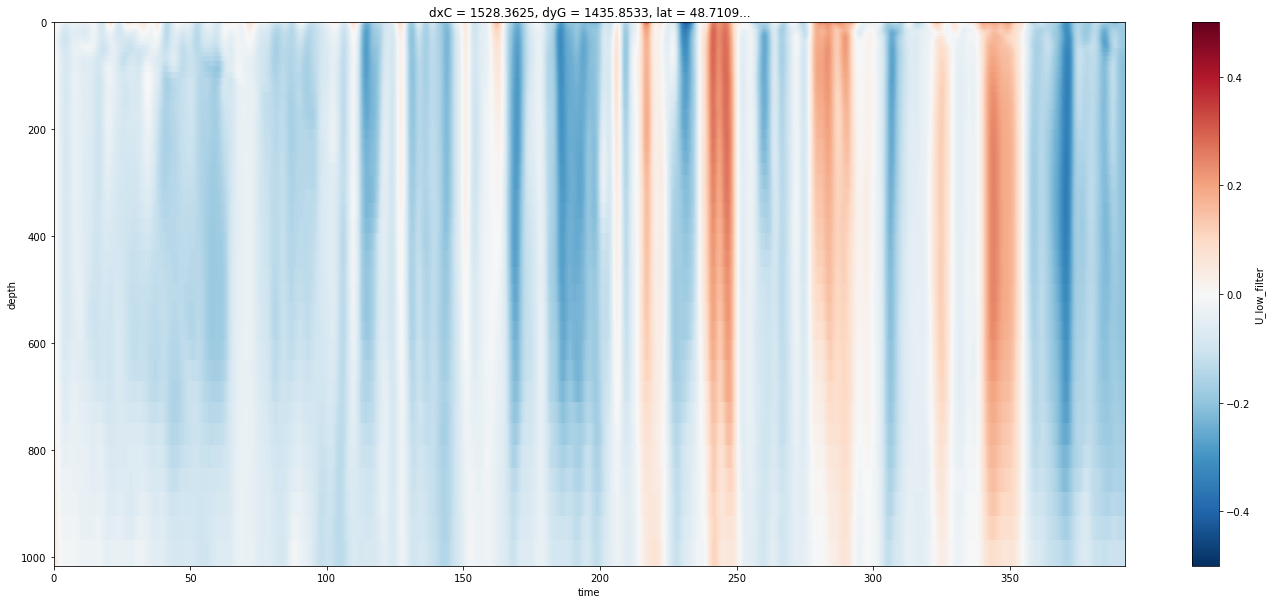

In [13]:
fig = plt.figure(figsize=(24,10))
ds_filter.U_low_filter.isel(lat=100,lon_g=100).plot(x='time', y='depth',vmin=-0.5,vmax=0.5,cmap='RdBu_r', yincrease=False)

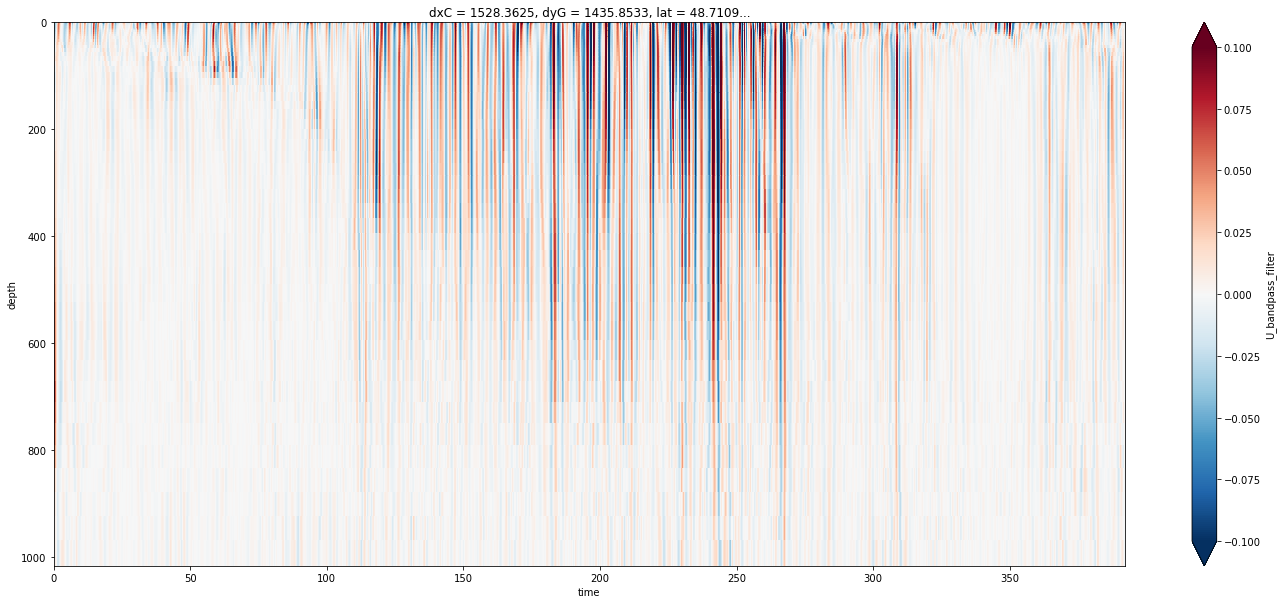

In [14]:
fig = plt.figure(figsize=(24,10))
ds_filter.U_bandpass_filter.isel(lat=100,lon_g=100).plot(x='time', y='depth',vmin=-0.1,vmax=0.1,cmap='RdBu_r', yincrease=False)

____________
## KE

In [8]:
out_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/LLC4320/filtered_uv_data/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds_U_bandpass = xr.open_zarr(out_dir_zarr+'U_bandpass_filter_rechunk.zarr')
ds_V_bandpass = xr.open_zarr(out_dir_zarr+'V_bandpass_filter_rechunk.zarr')
ds_U_lowpass = xr.open_zarr(out_dir_zarr+'U_lowpass_filter_rechunk.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_zarr+'V_lowpass_filter_rechunk.zarr')

ds_filter = xr.merge([ds_U_bandpass,ds_V_bandpass,ds_U_lowpass,ds_V_lowpass,grid])

print(ds_filter)
print('\n data size: %.1f GB' %(ds_filter.nbytes / 1e9))

<xarray.Dataset>
Dimensions:            (depth: 40, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 8761)
Coordinates:
  * depth              (depth) float64 0.5 1.57 2.79 4.185 ... 441.3 473.3 506.5
    dxC                (lat, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    dyG                (lat, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
  * lat                (lat) float64 47.4 47.42 47.43 ... 49.96 49.98 49.99
  * lon_g              (lon_g) float64 -18.04 -18.02 -18.0 ... -14.4 -14.38
    rAw                (lat, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
  * time               (time) datetime64[ns] 2011-09-13 ... 2012-09-12
    dxG                (lat_g, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    dyC                (lat_g, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
  * lat_g              (lat_g) float64 47.4 47.41 47.42 ... 49.96 49.97 49.98
  * lon                (lon) float64 

In [9]:
ds_filter = generate_grid_ds(ds_filter, {'Z':'depth'})

gridx = xgcm.Grid(ds_filter, coords={'X':{'center':'lon', 'left':'lon_g'},
                                     'Y':{'center':'lat', 'left':'lat_g'},
                                     'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic):
  * center   lat --> left
  * left     lat_g --> center
Z Axis (not periodic):
  * center   depth --> left
  * left     depth_left --> center


In [10]:
KE_low_filter = (gridx.interp(ds_filter['U_low_filter']**2,'X') + gridx.interp(ds_filter['V_low_filter']**2,'Y'))/2 # KE
KE_bandpass_filter = (gridx.interp(ds_filter['U_bandpass_filter']**2,'X') + gridx.interp(ds_filter['V_bandpass_filter']**2,'Y'))/2 # KE

KE_low_filter_smean = KE_low_filter.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon'])
KE_bandpass_filter_smean = KE_bandpass_filter.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon'])
KE_low_filter_tmean = KE_low_filter.mean(['depth','time'])
KE_bandpass_filter_tmean = KE_bandpass_filter.mean(['depth','time'])

KE_low_filter_smean = np.real(KE_low_filter_smean).rename('KE_low_filter_smean')     
KE_bandpass_filter_smean = np.real(KE_bandpass_filter_smean).rename('KE_bandpass_filter_smean')     
KE_low_filter_tmean = np.real(KE_low_filter_tmean).rename('KE_low_filter_tmean')     
KE_bandpass_filter_tmean = np.real(KE_bandpass_filter_tmean).rename('KE_bandpass_filter_tmean')     

KE_mean = xr.merge([KE_low_filter_smean,KE_bandpass_filter_smean,KE_low_filter_tmean,KE_bandpass_filter_tmean])
print(KE_mean)

file_out = out_dir_zarr+'/KE_mean.zarr'
KE_mean.to_zarr(file_out, mode='w')          

<xarray.Dataset>
Dimensions:                   (depth: 40, lat: 201, lon: 177, time: 8761)
Coordinates:
  * time                      (time) datetime64[ns] 2011-09-13 ... 2012-09-12
  * depth                     (depth) float64 0.5 1.57 2.79 ... 473.3 506.5
  * lat                       (lat) float64 47.4 47.42 47.43 ... 49.98 49.99
  * lon                       (lon) float64 -18.03 -18.01 ... -14.39 -14.36
Data variables:
    KE_low_filter_smean       (time, depth) float32 dask.array<chunksize=(8761, 1), meta=np.ndarray>
    KE_bandpass_filter_smean  (time, depth) float32 dask.array<chunksize=(8761, 1), meta=np.ndarray>
    KE_low_filter_tmean       (lat, lon) float32 dask.array<chunksize=(1, 176), meta=np.ndarray>
    KE_bandpass_filter_tmean  (lat, lon) float32 dask.array<chunksize=(1, 176), meta=np.ndarray>


In [10]:
ds_KE = xr.open_zarr(out_dir_zarr+'KE_mean.zarr')
ds_KE

<xarray.Dataset>
Dimensions:                   (depth: 40, lat: 201, lon: 177, time: 8761)
Coordinates:
  * depth                     (depth) float64 0.5 1.57 2.79 ... 473.3 506.5
  * lat                       (lat) float64 47.4 47.42 47.43 ... 49.98 49.99
  * lon                       (lon) float64 -18.03 -18.01 ... -14.39 -14.36
  * time                      (time) datetime64[ns] 2011-09-13 ... 2012-09-12
Data variables:
    KE_bandpass_filter_smean  (time, depth) float32 dask.array<chunksize=(8761, 1), meta=np.ndarray>
    KE_bandpass_filter_tmean  (lat, lon) float32 dask.array<chunksize=(1, 176), meta=np.ndarray>
    KE_low_filter_smean       (time, depth) float32 dask.array<chunksize=(8761, 1), meta=np.ndarray>
    KE_low_filter_tmean       (lat, lon) float32 dask.array<chunksize=(1, 176), meta=np.ndarray>

In [11]:
out_dir = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds_MLD = ds_MLD.assign_coords(time=time_day) 
ds_MLD

<xarray.Dataset>
Dimensions:     (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Dimensions without coordinates: lat, lon
Data variables:
    mld_filter  (time, lat, lon) float32 dask.array<chunksize=(9415, 201, 177), meta=np.ndarray>

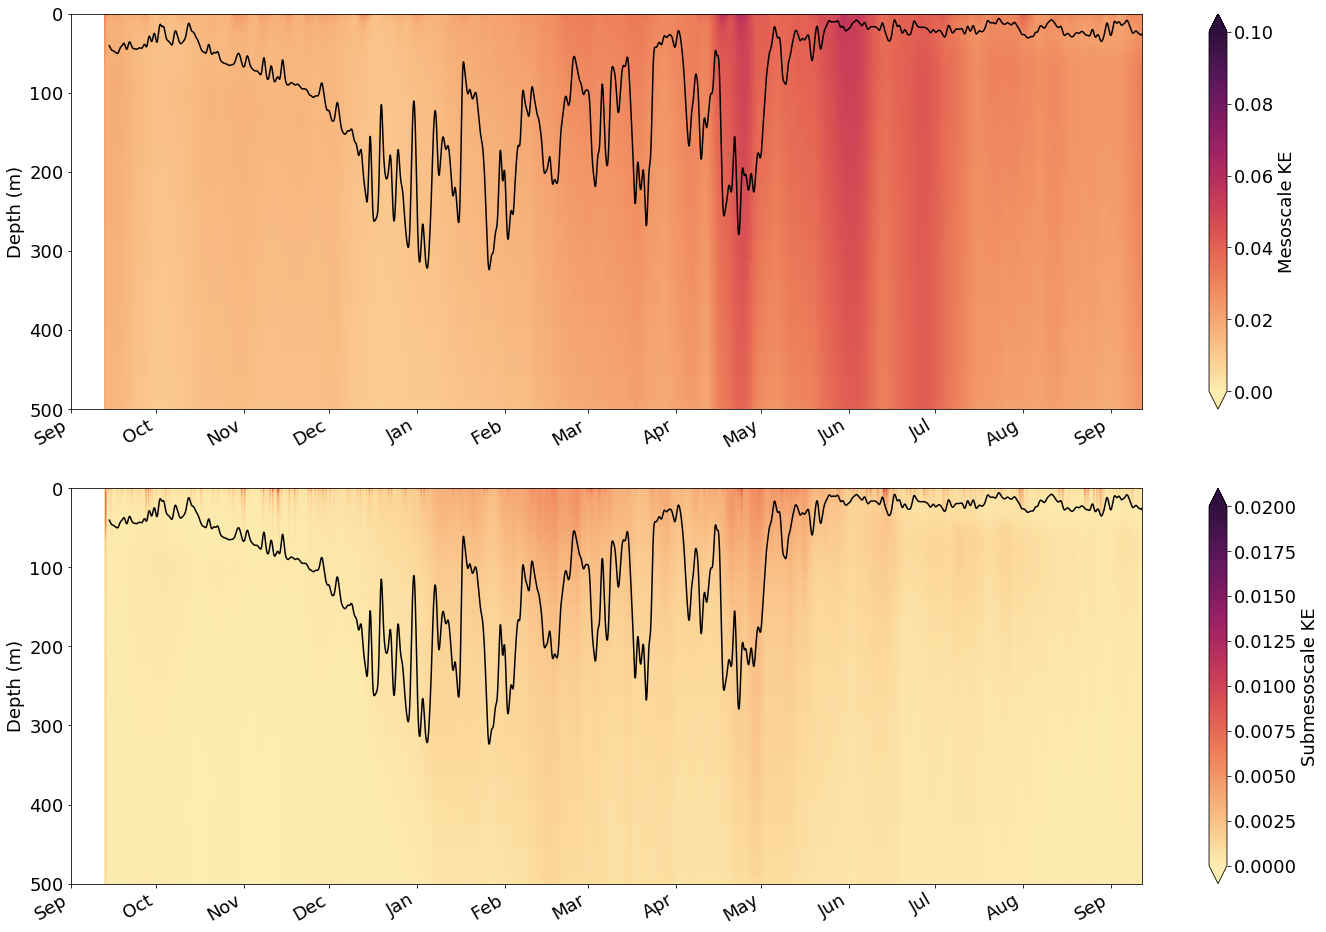

In [16]:
font_size = 18

fig = plt.figure(figsize=(24,16))

ax = plt.subplot(211)
cax=(ds_KE.KE_low_filter_smean).plot(x='time', y='depth', vmin=0, vmax=0.1, cmap=cm.matter, add_colorbar = False, yincrease=False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Mesoscale KE', fontsize=font_size)
ds_MLD.mld_filter.isel(time=slice(0,8761)).mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])

ax = plt.subplot(212)
cax=(ds_KE.KE_bandpass_filter_smean).plot(x='time', y='depth', vmin=0, vmax=0.02, cmap=cm.matter, add_colorbar = False, yincrease=False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Submesoscale KE', fontsize=font_size)
ds_MLD.mld_filter.isel(time=slice(0,8761)).mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/KE.png')

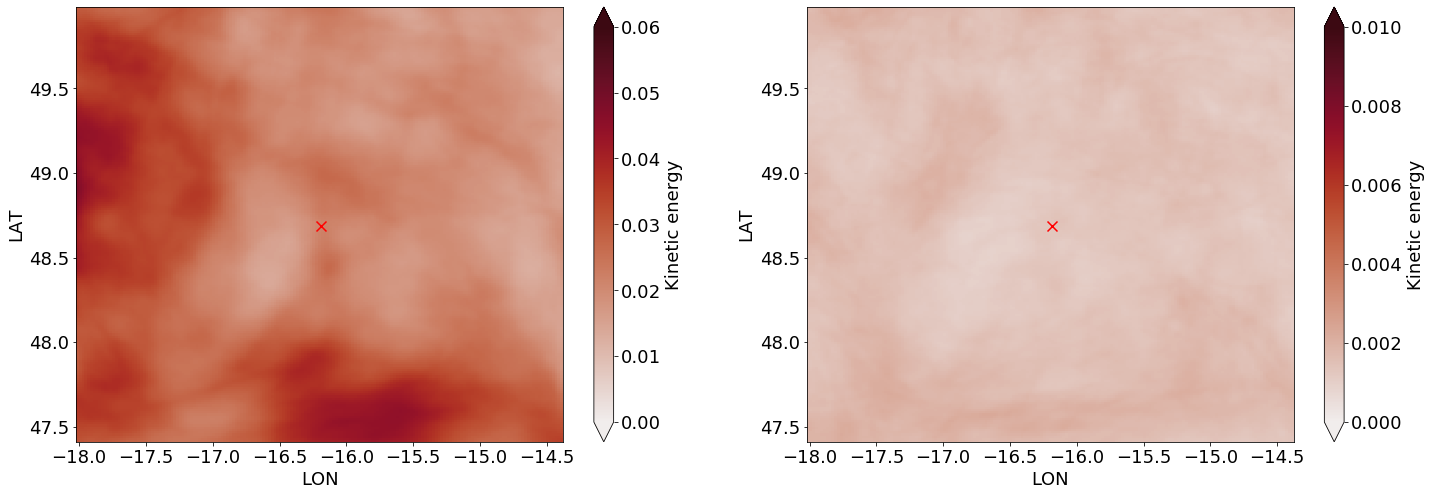

In [32]:
font_size = 18

fig = plt.figure(figsize=(24,8))

ax = plt.subplot(121)
cax=(ds_KE.KE_low_filter_tmean).isel(lat=slice(1,-1),lon=slice(1,-1)).plot(x='lon', y='lat', vmin=0, vmax=0.06, cmap=cm.amp, add_colorbar = False)
ax.scatter(-16.1875,48.6875,s=100,marker='x',color='r')
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Kinetic energy', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(122)
cax=(ds_KE.KE_bandpass_filter_tmean).isel(lat=slice(1,-1),lon=slice(1,-1)).plot(x='lon', y='lat', vmin=0, vmax=0.01, cmap=cm.amp, add_colorbar = False)
ax.scatter(-16.1875,48.6875,s=100,marker='x',color='r')
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Kinetic energy', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

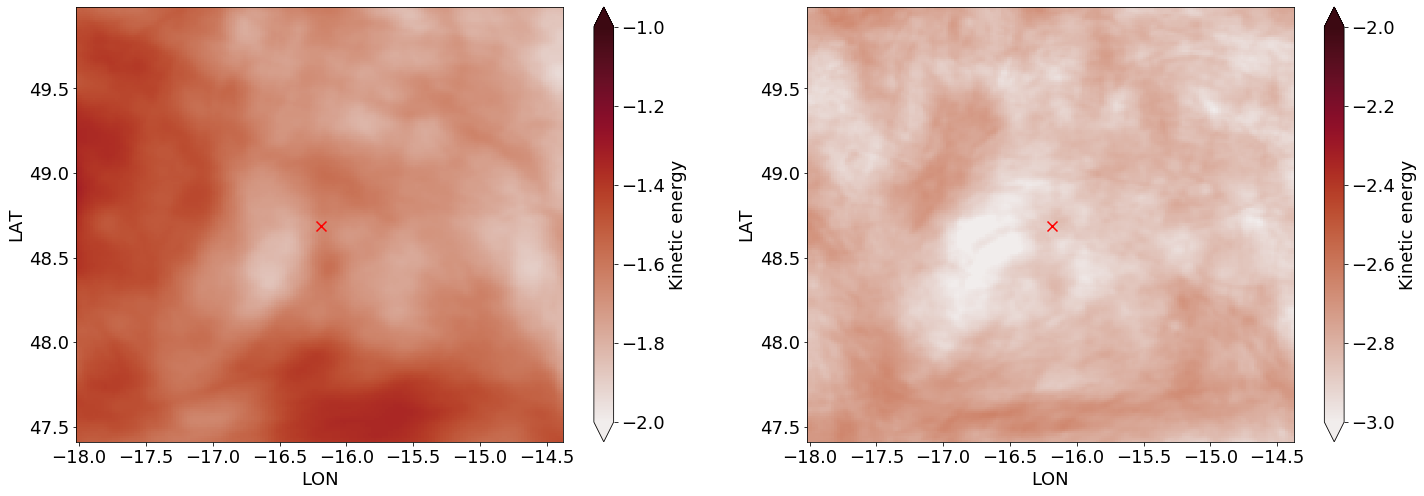

In [31]:
font_size = 18

fig = plt.figure(figsize=(24,8))

ax = plt.subplot(121)
cax=np.log10(ds_KE.KE_low_filter_tmean).isel(lat=slice(1,-1),lon=slice(1,-1)).plot(x='lon', y='lat', vmin=-2, vmax=-1, cmap=cm.amp, add_colorbar = False)
ax.scatter(-16.1875,48.6875,s=100,marker='x',color='r')
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Kinetic energy', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(122)
cax=np.log10(ds_KE.KE_bandpass_filter_tmean).isel(lat=slice(1,-1),lon=slice(1,-1)).plot(x='lon', y='lat', vmin=-3, vmax=-2, cmap=cm.amp, add_colorbar = False)
ax.scatter(-16.1875,48.6875,s=100,marker='x',color='r')
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Kinetic energy', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

In [10]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
